In [200]:
# Dữ liệu sử dụng là một tập dữ liệu về thẻ tín dụng, bao gồm thông tin cá nhân và tài chính của khách hàng.
#Các thuộc tính bao gồm:
#ID khách hàng, giới tính, sở hữu ô tô và bất động sản,số lượng con cái, thu nhập, loại thu nhập,
# trình độ học vấn, tình trạng hôn nhân,cách thức sống, ngày sinh, ngày bắt đầu làm việc,
#có sở hữu điện thoại và email không,  nghề nghiệp, và số lượng thành viên trong gia đình.


# Dữ liệu đã được phân tích rõ trong bản báo cáo.

# Tên thành viên
#   1 NGUYỄN THỊ THU YẾN - 52000869
#   2 NGUYỄN KHẮC VĂN - 52000868
#   3 TRƯƠNG THÔNG THẾ THÁI - 52000714


# Import các thư viện cần thiết

In [201]:

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    print('Environment: Google Colab')
    !pip install catboost
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import Dense, Dropout


from imblearn.over_sampling import SMOTE
import itertools
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier



from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Environment: Google Colab
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


# 1.1 Đọc dữ liệu, thay đổi tên cột để chuẩn bị dữ liệu làm việc

In [202]:
# Đọc data
data = pd.read_csv("credit-card-approval-prediction/application_record.csv")
record = pd.read_csv("credit-card-approval-prediction/credit_record.csv")

In [203]:
plt.rcParams['figure.facecolor'] = 'white'

In [204]:
all_data=[data,record]

data_names=['data','record']

In [205]:
# Thông tin data
for curr_data,name in zip(all_data, data_names):
    print(f'Số phần tử thực của {name}: {data.shape}')
    print(f'Thông tin dữ liệu {name} :\n \n')
    print(curr_data.info())
    print('*'*40)
    print (f'Các cột trong bảng {name}  \n \n {curr_data.columns}')


Số phần tử thực của data: (438557, 18)
Thông tin dữ liệu data :
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  F

In [206]:
# Tìm tất cả các tài khoản người dùng mở trong tháng
# nhóm DataFrame theo cột "ID" và tính giá trị tối thiểu của cột "MONTHS_BALANCE" cho mỗi nhóm
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
# Đổi tên cột "MONTHS_BALANCE" trong DataFrame đầu tháng thành "begin_month1".
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month1'})
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Tạo một cột mới có tên là "dep_value" trong DataFrame ghi dữ liệu dựa trên giá trị trong cột "STATUS". Đặt "Yes" trong cột "dep_value" cho các hàng mà cột "STATUS" có giá trị '2', '3', '4' hoặc '5'.

In [207]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes'
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes'

Tạo một cột mới 'dep_value' trong DataFrame "cpunt" dựa trên số lần xuất hiện của 'dep_value' trong DataFrame "record". Sau đó, hợp nhất thông tin này vào DataFrame "new_data" dựa trên cột "ID" và tạo một cột mới 'target' dựa trên cột 'dep_value'.



In [208]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0
# gộp thông tin từ hai bảng dữ liệu để tạo ra một DataFrame mới new_data với cột target được tạo ra
# để sử dụng trong việc dự đoán xác suất duy trì thẻ tín dụng

In ấn số lượng giá trị duy nhất trong cột 'dep_value' của DataFrame "cpunt" và sau đó in số lượng giá trị chuẩn hóa.

In [209]:
print(cpunt['dep_value'].value_counts())
print(cpunt['dep_value'].value_counts(normalize=True))

No     45318
Yes      667
Name: dep_value, dtype: int64
No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64


Đổi tên các cột trong DataFrame "new_data" bằng cách sử dụng phương pháp rename.

In [210]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)
# Xử lý các giá trị bị thiếu trong new_data DataFrame bằng phương thức dropna.
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()
new_data

,ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,...,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month1,dep_value,target
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1


Tạo một bảng giá trị (IV) cho các biến trong DataFrame "new_data", sau đó loại bỏ một số biến được chỉ định trong danh sách tên.

Tại đây khởi tạo một bảng IV với tên biến trong cột biến và một cột giữ chỗ 'IV'. Sau đó, nó lặp qua danh sách tên và loại bỏ các hàng tương ứng với các biến được chỉ định từ bảng IV.

In [211]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)
ivtable


,variable,IV
1,Gender,None
2,Car,None
3,Reality,None
4,ChldNo,None
5,inc,None
6,inctp,None
7,edutp,None
8,famtp,None
9,houtp,None
10,DAYS_BIRTH,None


# 1.2 Tạo một số hàm hỗ trợ


Định nghĩa một hàm calc_iv để tính Giá trị(IV) cho một đặc trưng cụ

*   List item
*   List item

thể trong DataFrame. Hàm này tính toán các thước đo khác nhau liên quan đến phân phối của đặc trưng đối với biến mục tiêu.

In [212]:
def calc_iv(df, feature, target, pr=False):
    lst = []
    #sẽ điền giá trị null cho các cột thiếu giá trị
    df[feature] = df[feature].fillna("NULL")

    # duyệt qua từng giá trị unique của cột feature.
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    # Kiểm tra và thay thế các giá trị vô cùng trong cột 'WoE' bằng 0.
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

Định nghĩa một hàm convert_dummy để chuyển đổi một đặc trưng phân loại thành biến giả bằng cách sử dụng mã hóa one-hot.

In [213]:
# hàm chuyển đổi biến phân loại thành biến dummy trong DataFrame, và loại bỏ một trong các cột dummy để tránh hiện tượng đa cộng tuyến trong quá trình xây dựng mô hình
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

Định nghĩa một hàm get_category để phân loại một cột số trong DataFrame thành các khoảng rời rạc. Hàm này sử dụng enther pd.qcut (cắt theo tỷ lệ) hoặc pd.cut (cắt theo chiều dài bằng nhau) dựa trên giá trị của tham số qcut

In [214]:
# hàm có chức năng chia biến liên tục thành các nhóm và thêm biến phân loại mới vào DataFrame
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
   # tạo dataframe mới
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df


Định nghĩa một hàm có tên là plot_confusion_matrix để trực quan hóa ma trận. Hàm này sử dụng Matplotlib để tạo một biểu đồ heatmap biểu diễn ma trận.

In [215]:
# hàm hỗ trợ vẽ biểu đồ
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 1.3 Phân tích dữ liệu, tiền xử lý dữ liệu

Chuyển đổi cột 'Gender' trong DataFrame "new_data" từ giá trị phân loại ('F' và 'M') thành giá trị số học (0 và 1), sau đó tính Giá trị(IV) cho biến đã được biến đổi này.

In [216]:
#đổi giá trị Male và Female thành 1 và 0
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
This variable's IV is: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


Thay thế giá trị 'N' và 'Y' trong cột 'Car' bằng 0 và 1 tương ứng.

In [217]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
This variable's IV is: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


Thay thế 'N' bằng 0 và 'Y' bằng 1 trong cột 'Reality', in số lượng giá trị, tính IV bằng cách sử dụng hàm calc_iv, cập nhật IV trong DataFrame "ivtable".

In [218]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
This variable's IV is: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


Chuyển đổi cột 'phone' sang kiểu chuỗi, sau đó in giá trị chuẩn hóa, loại bỏ các hàng mà 'phone' là 'nan', và cuối cùng tính toán Giá trị(IV) bằng cách sử dụng hàm calc_iv.

In [219]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


In giá trị chuẩn hóa, sau đó chuyển đổi cột 'email' sang kiểu chuỗi, và cuối cùng tính Giá trị (IV) bằng cách sử dụng hàm calc_iv.

In [220]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


Xử lý cột 'wkphone' theo cách tương tự như mã nguồn trước. Đầu tiên, chuyển đổi 'wkphone' sang kiểu chuỗi, tính toán Giá trị(IV) bằng cách sử dụng hàm calc_iv, loại bỏ các hàng mà 'wkphone' là 'nan', và sau đó cập nhật IV trong DataFrame "ivtable".

In [221]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


Phân loại cột 'ChldNo' trong DataFrame "new_data". Nếu giá trị trong cột 'ChldNo' lớn hơn hoặc bằng 2, sẽ thay thế nó bằng '2More'.

In [222]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
2More     3108
1         6118
Name: ChldNo, dtype: int64


Tính Giá trị (IV) cho cột 'ChldNo' trong DataFrame "new_data" sau khi phân loại nó thành các nhóm khác nhau.

In [223]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [224]:
new_data = convert_dummy(new_data,'ChldNo')

Thực hiện một số xử lý tiền xử lý trên cột 'inc' (thu nhập) trong DataFrame "new_data". Cụ thể, chuyển đổi cột 'inc' thành kiểu đối tượng, và chia giá trị cho 10,000

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


<Axes: ylabel='Frequency'>

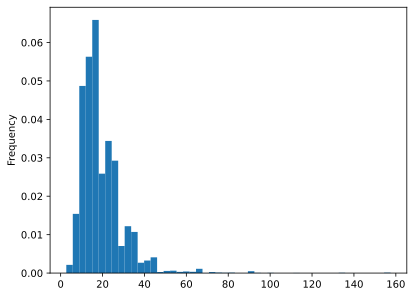

In [225]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

Tính toán tuổi từ cột 'DAYS_BIRTH' trong DataFrame "new_data", sau đó phân tích phân phối tuổi bằng cách sử dụng hàm đếm giá trị (value counts) và một biểu đồ histogram.

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


<Axes: ylabel='Frequency'>

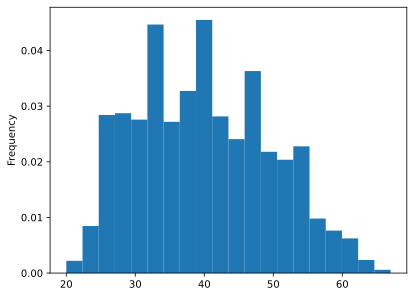

In [226]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

Phân loại cột 'Age' thành năm nhóm bằng cách sử dụng hàm get_category, sau đó tính Giá trị (IV) cho biến nhóm mới ('gp_Age').

In [227]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [228]:
new_data = convert_dummy(new_data,'gp_Age')

Tính số năm làm việc ('worktm') dựa trên cột 'DAYS_EMPLOYED' trong DataFrame "new_data". Sau khi tính toán thời gian làm việc, xử lý các giá trị âm (có thể chỉ ra dữ liệu thiếu hoặc dữ liệu ngoại lệ) bằng cách thay thế chúng bằng NaN, và sau đó điền giá trị NaN bằng giá trị trung bình của cột 'worktm'.

<Axes: ylabel='Frequency'>

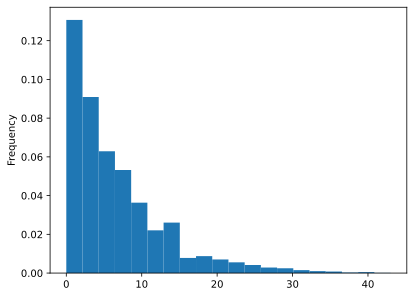

In [229]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

Phân loại cột 'worktm' (số năm làm việc) thành năm nhóm bằng cách sử dụng hàm get_category, sau đó tính Giá trị (IV) cho biến nhóm mới ('gp_worktm').

In [230]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [231]:
new_data = convert_dummy(new_data,'gp_worktm')
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: famsize, dtype: int64

Thao tác trên cột 'famsize' trong DataFrame "new_data". Sau đó, chuyển đổi nó thành kiểu số nguyên, tạo một cột mới 'famsizegp', phân loại nó, và sau đó tính Giá trị(IV) cho biến đã phân loại.

In [232]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [233]:
new_data = convert_dummy(new_data,'famsizegp')


Chỉnh sửa giá trị của cột 'inctp' bằng cách kết hợp các hạng mục 'Pensioner' và 'Student' thành 'State servant'. Sau các sửa đổi này, tính Giá trị (IV) cho biến 'inctp'.

In [234]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: inctp, dtype: int64
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: inctp, dtype: float64
This variable's IV is: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [235]:
new_data = convert_dummy(new_data,'inctp')

Phân loại lại cột 'occyp' (loại nghề nghiệp) trong DataFrame "new_data" bằng cách nhóm một số nghề nghiệp cụ thể vào các danh mục rộng hơn. Sau quá trình phân loại lại này, tính Giá trị (IV) cho biến 'occyp' đã được sửa đổi

In [236]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [237]:
new_data = convert_dummy(new_data,'occyp')

Tính Giá trị (IV) cho cột 'houtp' (loại nhà ở) trong DataFrame "new_data".

In [238]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [239]:
new_data = convert_dummy(new_data,'houtp')

Chỉnh sửa cột 'edutp' (loại học vấn) trong DataFrame "new_data" bằng cách thay thế hạng mục 'Academic degree' bằng 'Higher education'. Sau khi sửa đổi này, tính Giá trị (IV) cho biến 'edutp' đã được sửa đổi.

In [240]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [241]:
new_data = convert_dummy(new_data,'edutp')

In [242]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Widow                   0.023076
Name: famtp, dtype: float64

In [243]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Widow                   0.023076
Name: famtp, dtype: float64

Tính Giá trị (IV) cho cột 'famtp' (tình trạng gia đình) trong DataFrame "new_data".

In [244]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [245]:
new_data = convert_dummy(new_data,'famtp')

Sắp xếp DataFrame "ivtable" theo Giá trị (IV) giảm dần, sau đó chỉnh sửa tên biến để đọc dễ hiểu hơn.

In [246]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
13,wkphone,0.002042


In [247]:
new_data

,ID,Gender,Car,Reality,inc,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
2,5008806.0,1.0,1.0,1.0,11.25,-21474.0,-1134.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5008808.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,5008809.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,5008810.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,5008811.0,0.0,0.0,1.0,27.0,-19110.0,-3051.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828.0,1.0,1.0,1.0,31.5,-17348.0,-2420.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
36453,5149834.0,0.0,0.0,1.0,15.75,-12387.0,-1325.0,1.0,0,1,...,0,0,0,1,0,0,0,0,0,0
36454,5149838.0,0.0,0.0,1.0,15.75,-12387.0,-1325.0,1.0,0,1,...,0,0,0,1,0,0,0,0,0,0
36455,5150049.0,0.0,0.0,1.0,28.35,-17958.0,-655.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [248]:
total_columns = len(new_data.columns)
print(f"Số lượng cột: {total_columns}\n")
print(f"Số lượng dòng: {new_data.shape[0]}\n")

categorical_columns = new_data.select_dtypes(include='object').columns.tolist()
total_categorical_columns = len(categorical_columns)
print(f"Số lượng cột thuộc loại categorical: {total_categorical_columns}")
print("Các cột thuộc loại categorical:", categorical_columns)

numerical_columns = new_data.select_dtypes(exclude='object').columns.tolist()
total_numerical_columns = len(numerical_columns)
print(f"\nSố lượng cột thuộc loại numerical: {total_numerical_columns}")
print("Các cột thuộc loại numerical:", numerical_columns)

total_labels = new_data['target'].nunique()
print(f"\nTổng số nhãn trong tập dữ liệu: {total_labels}")
print(new_data['target'].value_counts())

Số lượng cột: 45

Số lượng dòng: 25134

Số lượng cột thuộc loại categorical: 6
Các cột thuộc loại categorical: ['inc', 'wkphone', 'phone', 'email', 'dep_value', 'target']

Số lượng cột thuộc loại numerical: 39
Các cột thuộc loại numerical: ['ID', 'Gender', 'Car', 'Reality', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'famsize', 'begin_month1', 'ChldNo_1', 'ChldNo_2More', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_Office apartment', 'houtp_Rented apartment', 'houtp_With parents', 'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary', 'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow']

Tổng số nhãn trong tập dữ liệu: 2
0    24712
1   

In [249]:
import plotly.express as px
fig=px.histogram(new_data,x='target',
                 color='target',
                 barmode='group',
                color_discrete_map={'0':'red','1':'green'}) # 0: không tiềm năng, 1: tiềm năng

fig.update_layout(title='<b>Số lượng khách hàng tiềm năng và không tiềm năng<b>',
                 title_font={'size':30},
                 paper_bgcolor='white',
                 plot_bgcolor='lightgrey',
                 showlegend=True)
fig.update_traces(marker_line_color='brown',marker_line_width=0.5,opacity=0.8)

In [250]:
new_data.groupby('target')['Car'].value_counts()

target  Car
0       0.0    14373
        1.0    10339
1       0.0      245
        1.0      177
Name: Car, dtype: int64

(-1.0999999999906405,
 1.0999999999995542,
 -1.099995418917978,
 1.0999987256549013)

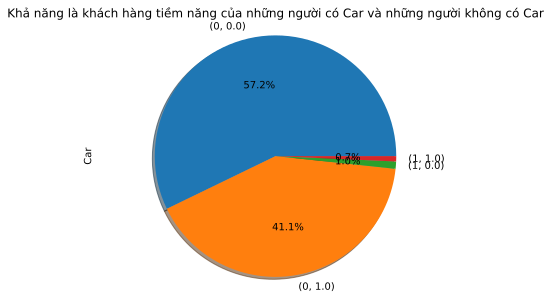

In [251]:
new_data.groupby('target')['Car'].value_counts().plot.pie(autopct ='%1.1f%%',shadow=True)
plt.title('Khả năng là khách hàng tiềm năng của những người có Car và những người không có Car')
plt.axis('equal')

In [252]:
new_data.groupby('target')['Gender'].value_counts()

target  Gender
0       0.0       15400
        1.0        9312
1       0.0         230
        1.0         192
Name: Gender, dtype: int64

(-1.0999984121848096,
 1.099999924389753,
 -1.0999949515984702,
 1.0999990101792703)

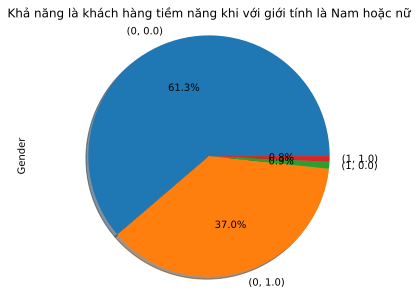

In [253]:
new_data.groupby('target')['Gender'].value_counts().plot.pie(autopct ='%1.1f%%',shadow=True)
plt.title('Khả năng là khách hàng tiềm năng khi với giới tính là Nam hoặc nữ')
plt.axis('equal')

In [254]:
new_data.groupby('target')['Age'].value_counts()

target  Age 
0       37.0    1017
        40.0     930
        34.0     895
        38.0     890
        28.0     885
                ... 
1       22.0       1
        23.0       1
        57.0       1
        60.0       1
        61.0       1
Name: Age, Length: 87, dtype: int64

In [255]:
import plotly.graph_objects as go
target_yes=new_data[new_data['target']==1]
target_no=new_data[new_data['target']==0]


fig=go.Figure()

fig.add_trace(go.Violin(x=target_yes['Age'],line_color='lightseagreen',y0=0,name='khách hàng tiềm năng '))

fig.add_trace(go.Violin(x=target_no['Age'],line_color='red',y0=0,name='khách hàng không tiềm năng'))

fig.update_traces(orientation='h',side='positive',meanline_visible=True)

fig.update_layout(title='<b>Phân bổ khách hàng tiềm năng và không tiềm năng theo độ tuổi<b>',
                 titlefont={'size':14},
                 xaxis_zeroline=False,
                 paper_bgcolor='lightgrey',
                 plot_bgcolor='lightgrey')

fig.update_xaxes(showgrid=False,title='<b>Tuổi<b>')
fig.update_traces(opacity=0.7)

In [256]:
new_data.groupby('target')['houtp_Office apartment'].value_counts()

target  houtp_Office apartment
0       0                         24518
        1                           194
1       0                           417
        1                             5
Name: houtp_Office apartment, dtype: int64

In [257]:
import plotly.graph_objects as go
target_yes=new_data[new_data['houtp_Office apartment']==1]
target_no=new_data[new_data['houtp_Office apartment']==0]


fig=go.Figure()

fig.add_trace(go.Violin(x=target_yes['Age'],line_color='lightseagreen',y0=0,name='khách hàng tiềm năng '))

fig.add_trace(go.Violin(x=target_no['Age'],line_color='red',y0=0,name='khách hàng không tiềm năng'))

fig.update_traces(orientation='h',side='positive',meanline_visible=True)

fig.update_layout(title='<b>Phân bổ khách hàng tiềm năng và không tiềm năng theo kiểu nhà sở hữu<b>',
                 titlefont={'size':14},
                 xaxis_zeroline=False,
                 paper_bgcolor='lightgrey',
                 plot_bgcolor='lightgrey')

fig.update_xaxes(showgrid=False,title='<b>Tuổi<b>')
fig.update_traces(opacity=0.7)

Định nghĩa biến mục tiêu Y và ma trận đặc trưng X cho một nhiệm vụ mô hình hóa dự đoán. Ở đây, Y đại diện cho biến mục tiêu ('target'), và X bao gồm một lựa chọn các đặc trưng từ DataFrame "new_data"

In [258]:
Y = new_data['target']
X = new_data[['ID','Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk',
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

Thực hiện tái chọn mẫu sử dụng Phương pháp Tổng hợp Thấp hơn Thiểu số (SMOTE) để cân bằng phân phối lớp trong biến mục tiêu Y.

In [259]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y) #tổng hợp dữ liệu thiểu số
X_balance = pd.DataFrame(X_balance, columns = X.columns)


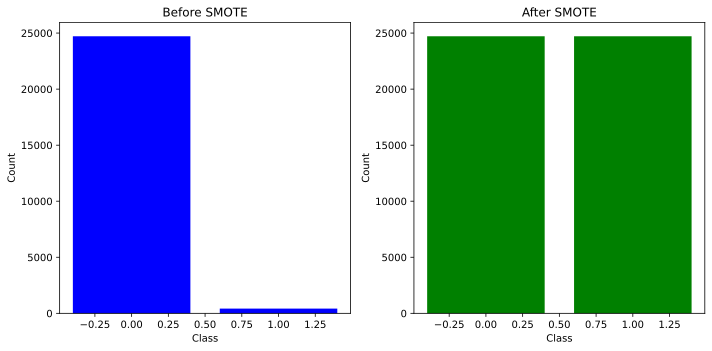

In [260]:
before_smote_counts = Y.value_counts()

after_smote_counts = pd.Series(Y_balance).value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].bar(before_smote_counts.index, before_smote_counts.values, color='blue')
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

axes[1].bar(after_smote_counts.index, after_smote_counts.values, color='green')
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Chia dữ liệu đã được tái chọn mẫu thành các tập huấn luyện và kiểm thử bằng cách sử dụng hàm train_test_split.

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance,
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

In [262]:
X_train.head()

,ID,Gender,Reality,ChldNo_1,ChldNo_2More,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
32515,5.046215e+06,0.0,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
14471,5.114645e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
16400,5.096682e+06,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
29956,5.065326e+06,0.0,1.0,0.640998,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
39904,5.105651e+06,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [263]:
y_test.head()

24205    0
39804    1
10003    0
45484    1
25645    1
Name: target, dtype: int64

Trích xuất cột 'ID' từ tập huấn luyện và testing

In [264]:
X_train_ID = X_train['ID']
X_test_ID = X_test['ID']

In [265]:
X_test_ID = X_test['ID']


In [266]:
X_test.head()

,ID,Gender,Reality,ChldNo_1,ChldNo_2More,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
24205,5.149085e+06,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
39804,5.135991e+06,0.000000,1.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,1.0,...,0,0,0,1,0,0,0,0,1,0
10003,5.061323e+06,0.000000,1.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,0
45484,5.047696e+06,0.000000,1.0,0.722721,0.0,0.277279,0.722721,0.0,0.277279,0.0,...,0,0,0,0,0,0,0,0,0,0
25645,5.050720e+06,0.184812,0.0,0.000000,0.0,0.184812,0.000000,0.0,1.000000,0.0,...,0,0,0,0,0,0,0,0,0,0


# 2.1 Giải quyết bài toán bằng các mô hình học máy

In [267]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score, auc

def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = metrics.accuracy_score(yt, yp)
    precision, recall, f_beta, _ = metrics.precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

def get_precision_recall(X_test, y_test, model):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    auc_score = auc(recall, precision)
    return auc_score

def get_f1_score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

training GaussianNB model

{'test Accuracy': 0.5557728621526841, 'train Accuracy': 0.556567233206151}
      0     1
0  1184  6230
1   357  7057


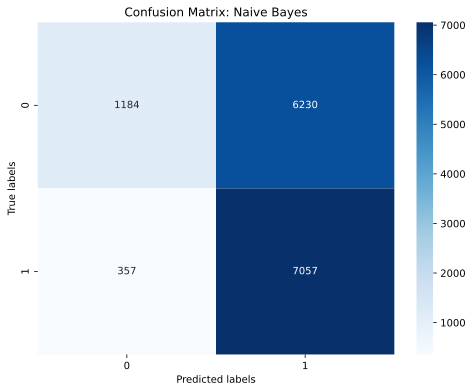

In [268]:
scores = []
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

y_predict = gaussian.predict(X_test)

gaussian_accuracy_before = accuracy_score(y_test, y_predict)
precision_recall_score = get_precision_recall(X_test, y_test, gaussian)
f1_score_value  = get_f1_score(X_test, y_test, gaussian)
scores.append(('Naive Bayes', gaussian_accuracy_before, precision_recall_score, f1_score_value ))

print(get_accuracy(X_train, X_test, y_train, y_test, gaussian))
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: Naive Bayes')
plt.show()

Decision tree model

{'test Accuracy': 0.9526571351497167, 'train Accuracy': 0.9586079315527807}
      0     1
0  7203   211
1   491  6923


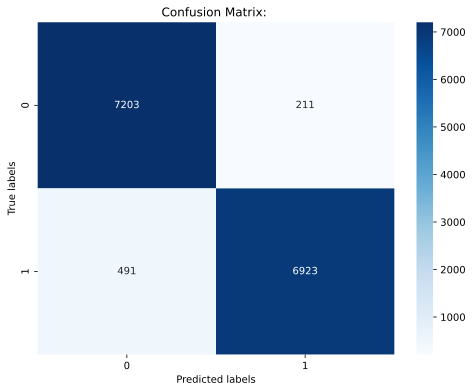

In [269]:
#decision tree
dt = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

dt_accuracy_before = accuracy_score(y_test, y_predict)

precision_recall_score = get_precision_recall(X_test, y_test, dt)
f1_score_value = get_f1_score(X_test, y_test, dt)
scores.append(('Decision Tree', dt_accuracy_before, precision_recall_score, f1_score_value))

print(get_accuracy(X_train, X_test, y_train, y_test, dt))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()


Random forest

{'test Accuracy': 0.9415295387105476, 'train Accuracy': 0.947884148456469}
      0     1
0  7316    98
1   769  6645


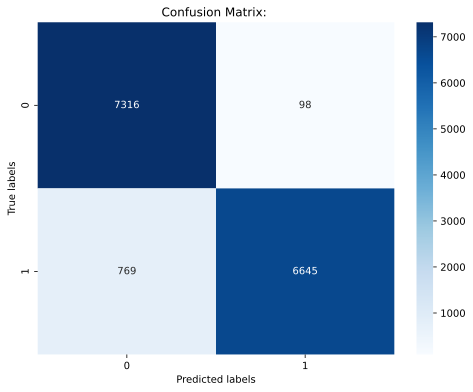

In [270]:
# Random forest
rf = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

rf_accuracy_before = accuracy_score(y_test, y_predict)

precision_recall_score = get_precision_recall(X_test, y_test, rf)
f1_score_value = get_f1_score(X_test, y_test, rf)
scores.append(('Random Forest', rf_accuracy_before, precision_recall_score, f1_score_value))

print(get_accuracy(X_train, X_test, y_train, y_test, rf))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

{'test Accuracy': 0.9072700296735905, 'train Accuracy': 0.9107989362932131}
      0     1
0  7329    85
1  1290  6124


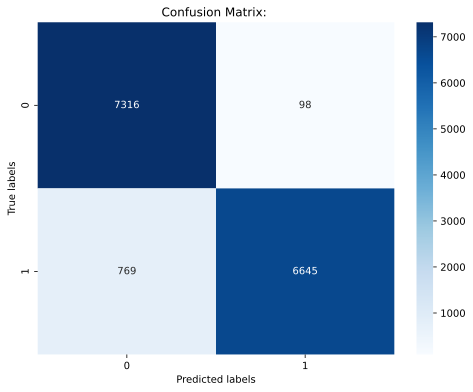

In [271]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)


gb_model.fit(X_train, y_train)
y_gb_predict = gb_model.predict(X_test)

gb_accuracy_before = accuracy_score(y_test, y_predict)

precision_recall_score = get_precision_recall(X_test, y_test, gb_model)
f1_score_value = get_f1_score(X_test, y_test, gb_model)
scores.append(('Gradient Boosting', gb_accuracy_before, precision_recall_score, f1_score_value))

print(get_accuracy(X_train, X_test, y_train, y_test, gb_model))
print(pd.DataFrame(confusion_matrix(y_test, y_gb_predict)))


conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

{'test Accuracy': 0.7980172646344753, 'train Accuracy': 0.8742051104173892}
      0     1
0  5977  1437
1  1558  5856


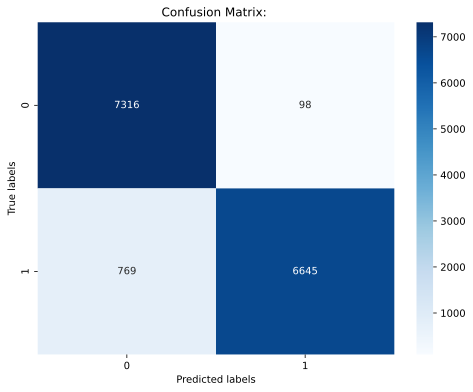

In [272]:
#knn
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)
y_knn_predict = knn_model.predict(X_test)

knn_accuracy_before = accuracy_score(y_test, y_knn_predict)
precision_recall_score = get_precision_recall(X_test, y_test, knn_model)
f1_score_value = get_f1_score(X_test, y_test, knn_model)
scores.append(('K-Nearest Neighbors', knn_accuracy_before, precision_recall_score, f1_score_value))

print(get_accuracy(X_train, X_test, y_train, y_test, knn_model))
print(pd.DataFrame(confusion_matrix(y_test, y_knn_predict)))


conf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

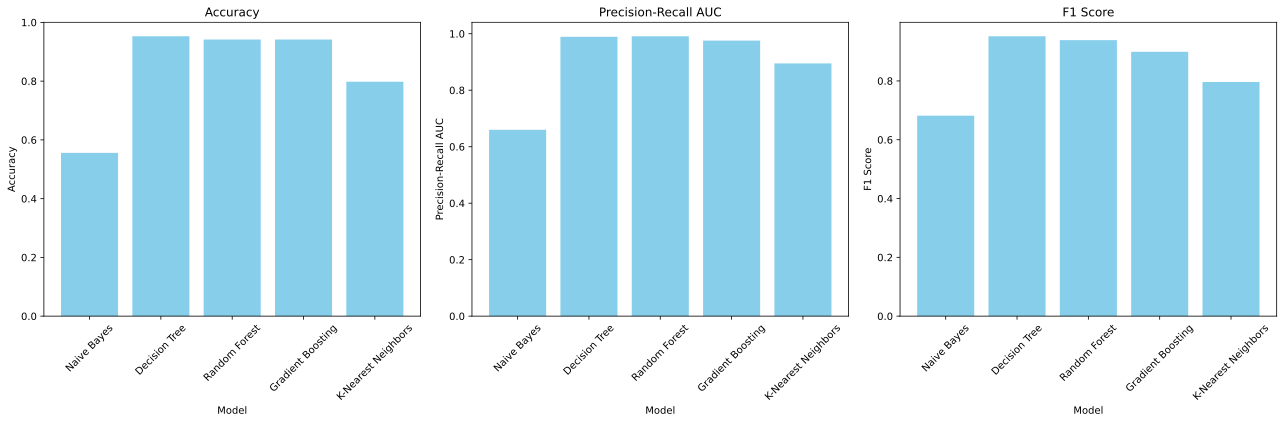

In [273]:
import matplotlib.pyplot as plt
labels = ['Accuracy', 'Precision-Recall AUC', 'F1 Score']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(len(labels)):
    ax = axs[i]
    models = [score[0] for score in scores]
    scores_i = [score[i + 1] for score in scores]

    ax.bar(models, scores_i, color='skyblue')
    ax.set_xlabel('Model')
    ax.set_ylabel(labels[i])
    ax.set_title(labels[i])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 3.1 Sử dụng Feed Forward Neural Network và Reccurent Neural Network để giải quyết bài toán

Mô hình Forward Neural Network


Epoch 1/50
1082/1082 [==============================] - 11s 9ms/step - loss: 6739.7617 - accuracy: 0.4971 - val_loss: 132.3845 - val_accuracy: 0.5000
Epoch 2/50
1082/1082 [==============================] - 3s 3ms/step - loss: 3519.8091 - accuracy: 0.5054 - val_loss: 5437.6968 - val_accuracy: 0.5000
Epoch 3/50
1082/1082 [==============================] - 3s 3ms/step - loss: 3261.7581 - accuracy: 0.4992 - val_loss: 1497.9414 - val_accuracy: 0.5000
Epoch 4/50
1082/1082 [==============================] - 4s 3ms/step - loss: 2485.5420 - accuracy: 0.5047 - val_loss: 9111.3975 - val_accuracy: 0.5000
Epoch 5/50
1082/1082 [==============================] - 4s 3ms/step - loss: 2384.3401 - accuracy: 0.4979 - val_loss: 2133.1829 - val_accuracy: 0.5000
Epoch 6/50
1082/1082 [==============================] - 3s 3ms/step - loss: 1919.1239 - accuracy: 0.4991 - val_loss: 4221.3979 - val_accuracy: 0.5000
Epoch 7/50
1082/1082 [==============================] - 3s 3ms/step - loss: 1446.6519 - accuracy: 0.

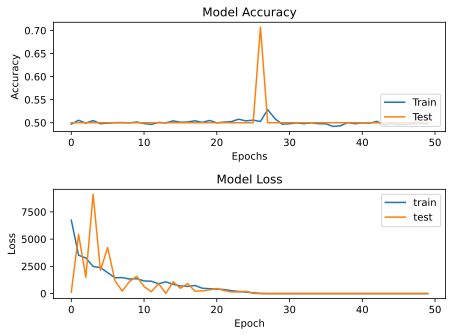

In [274]:
# Chuyển đổi dữ liệu đầu vào sang kiểu dữ liệu float32
X_train_FNN = np.asarray(X_train).astype(np.float32)
X_test_FNN = np.asarray(X_test).astype(np.float32)
y_train_FNN = np.asarray(y_train).astype(np.float32)
y_test_FNN = np.asarray(y_test).astype(np.float32)

#xây dựng model FNN bằng cách sử dụng Sequential gồm 3 lớp Dense
fnn_model = Sequential([
    #lớp đầu tiên Số lượng neuron (units) là 64
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# chạy mô hình  mô hình với optimizer là 'adam', hàm mất mát là 'binary_crossentropy', đo hiệu suất là accuracy
fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# huấn luyện mô hình
fnn = fnn_model.fit(X_train_FNN, y_train_FNN, epochs=50, batch_size=32, validation_data=(X_test_FNN, y_test_FNN))
fnn_loss, fnn_accuracy = fnn_model.evaluate(X_test_FNN, y_test_FNN)

print(f'FNN Accuracy Score is: {fnn_accuracy:.4f}')

%matplotlib inline
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(fnn.history['accuracy'])
plt.plot(fnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(fnn.history['loss'])
plt.plot(fnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

print(f'FNN Accuracy Score is: {fnn_accuracy:.4f}')

Mô hình Reccurent Neural Network

Epoch 1/50
1082/1082 [==============================] - 6s 4ms/step - loss: 6930.2681 - accuracy: 0.4992 - val_loss: 690.4736 - val_accuracy: 0.5000
Epoch 2/50
1082/1082 [==============================] - 3s 3ms/step - loss: 2595.6057 - accuracy: 0.5029 - val_loss: 594.2010 - val_accuracy: 0.5000
Epoch 3/50
1082/1082 [==============================] - 3s 3ms/step - loss: 2816.0750 - accuracy: 0.5008 - val_loss: 5971.9053 - val_accuracy: 0.5000
Epoch 4/50
1082/1082 [==============================] - 4s 4ms/step - loss: 2320.0310 - accuracy: 0.4980 - val_loss: 1061.6006 - val_accuracy: 0.5000
Epoch 5/50
1082/1082 [==============================] - 4s 4ms/step - loss: 2630.5073 - accuracy: 0.5005 - val_loss: 168.8524 - val_accuracy: 0.5000
Epoch 6/50
1082/1082 [==============================] - 4s 3ms/step - loss: 2589.4333 - accuracy: 0.5001 - val_loss: 1501.9727 - val_accuracy: 0.5000
Epoch 7/50
1082/1082 [==============================] - 4s 3ms/step - loss: 2298.9304 - accuracy: 0.500

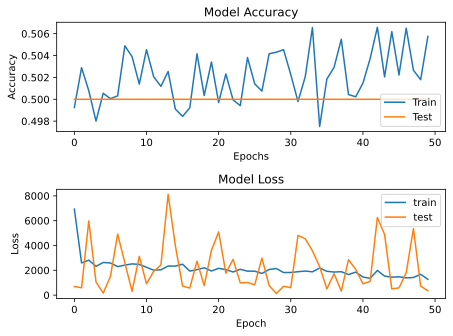

In [275]:
X_train_3D = X_train_FNN.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_3D = X_test_FNN.reshape((X_test_FNN.shape[0], 1, X_test_FNN.shape[1]))
y_train_RNN = np.asarray(y_train_FNN).astype(np.float32)
y_test_RNN = np.asarray(y_test_FNN).astype(np.float32)
# Tạo mô hình RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(1, X_train_FNN.shape[1])),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn = rnn_model.fit(X_train_3D, y_train_RNN, epochs=50, batch_size=32, validation_data=(X_test_3D, y_test_RNN))

rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_3D, y_test_RNN)
print(f'RNN Accuracy Score is: {rnn_accuracy:.4f}')

%matplotlib inline
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

print(f'RNN Accuracy Score is: {fnn_accuracy:.4f}')

# 4.1 Áp dụng các kỹ thuật tránh Overfiting các mô hình học máy

 hình Naive Bayes Accuracy after 0.55577
      0     1
0  7188   226
1   227  7187


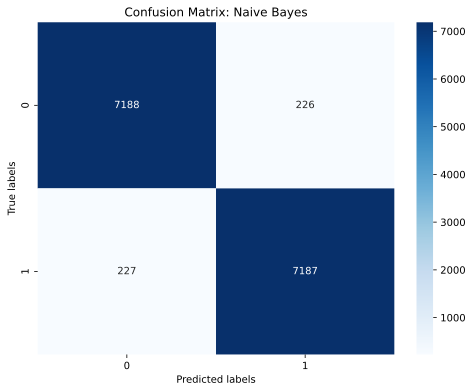

In [288]:
scores_after = []

# Tạo và huấn luyện mô hình Naive Bayes với Laplace Smoothing
nb_model_regularized = GaussianNB(var_smoothing=1e-9)
nb_model_regularized.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình sau khi điều chỉnh
y_nb_predict_after = nb_model_regularized.predict(X_test)
nb_accuracy_after = accuracy_score(y_test, y_nb_predict_after)

precision_recall_score_after = get_precision_recall(X_test, y_test, nb_model_regularized)
f1_score_value_after = get_f1_score(X_test, y_test, nb_model_regularized)
scores_after.append(('Naive Bayes', nb_accuracy_after, precision_recall_score_after, f1_score_value_after ))

print(' Naive Bayes Accuracy after {:.5}'.format(nb_accuracy_after))
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

Accuracy before: 0.9526571351497167
Accuracy after: 0.9694496897760992
      0     1
0  7188   226
1   227  7187


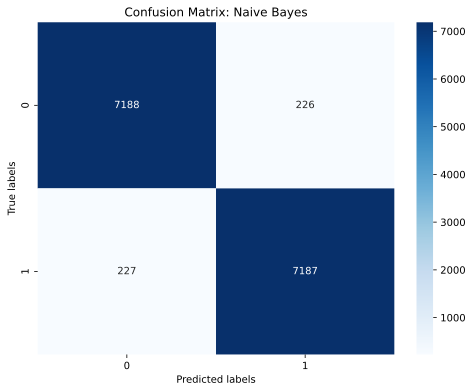

In [289]:
dt_after = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=12,
    min_samples_leaf=12,
    random_state=1024
)

dt_after.fit(X_train, y_train)
y_predict = dt_after.predict(X_test)

dt_accuracy_after = accuracy_score(y_test, y_predict)
precision_recall_score = get_precision_recall(X_test, y_test, dt_after)
f1_score_value  = get_f1_score(X_test, y_test, dt_after)
scores_after.append(('Decision tree', dt_accuracy_after, precision_recall_score, f1_score_value ))

dt_accuracy_after = accuracy_score(y_test, y_predict)
print("Accuracy before:", dt_accuracy_before)
print("Accuracy after:", dt_accuracy_after)
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

Accuracy Score before is  0.9526571351497167
Accuracy Score after : 0.9411923388184515
      0     1
0  7280   134
1   738  6676


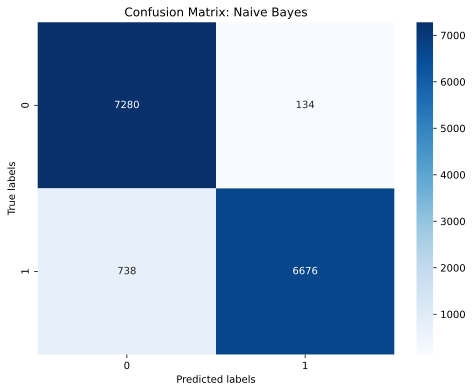

In [292]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=8, random_state=42)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

rf_accuracy_after = accuracy_score(y_test, y_predict)
precision_recall_score = get_precision_recall(X_test, y_test, rf)
f1_score_value  = get_f1_score(X_test, y_test, rf)
scores_after.append((' Random Forest', rf_accuracy_after, precision_recall_score, f1_score_value ))


print('Accuracy Score before is ', dt_accuracy_before)
rf_accuracy_after = accuracy_score(y_test, y_predict)
print("Accuracy Score after :", rf_accuracy_after)
conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

Accuracy before: 0.9415295387105476
Accuracy after: 0.9072700296735905
      0     1
0  7188   226
1   227  7187


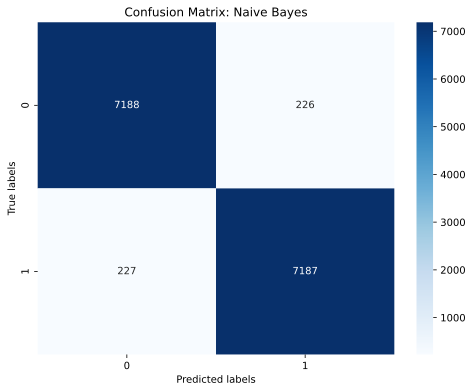

In [291]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_gb_predict = gb_model.predict(X_test)

gb_accuracy_after = accuracy_score(y_test, y_gb_predict)

precision_recall_score = get_precision_recall(X_test, y_test, gb_model)
f1_score_value  = get_f1_score(X_test, y_test, gb_model)
scores_after.append(('Gradient Boosting', gb_accuracy_after, precision_recall_score, f1_score_value ))

print("Accuracy before:", gb_accuracy_before)
print("Accuracy after:", gb_accuracy_after)

conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

KNN Accuracy before is 0.79802
KNN Accuracy Score is 0.97174
      0     1
0  7280   134
1   738  6676


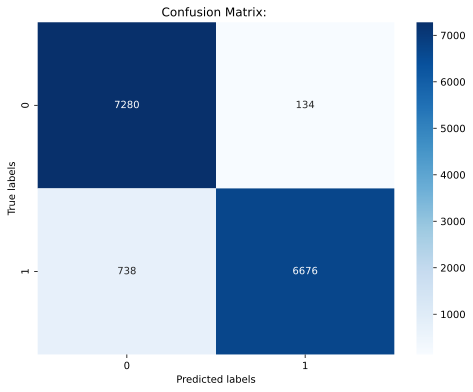

In [296]:
from sklearn.preprocessing import StandardScaler
# K-Nearest Neighbors (KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_model.fit(X_train_scaled, y_train)

y_knn_predict = knn_model.predict(X_test_scaled)
knn_accuracy_after = accuracy_score(y_test, y_knn_predict)
precision_recall_score = get_precision_recall(X_test, y_test, knn_model)
f1_score_value  = get_f1_score(X_test_scaled, y_test, knn_model)
scores_after.append(('KNN', knn_accuracy_after, precision_recall_score, f1_score_value ))


print('KNN Accuracy before is {:.5}'.format(knn_accuracy_before))
print('KNN Accuracy Score is {:.5}'.format(knn_accuracy_after))

conf_matrix = confusion_matrix(y_test, y_predict)
print(pd.DataFrame(conf_matrix))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: ')
plt.show()

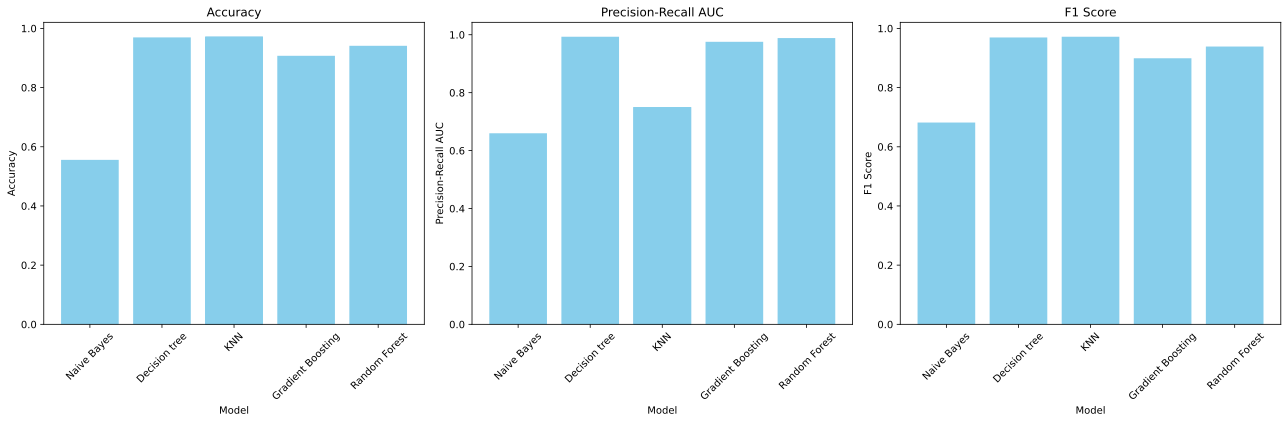

In [297]:
labels = ['Accuracy', 'Precision-Recall AUC', 'F1 Score']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(len(labels)):
    ax = axs[i]
    models = [score[0] for score in scores_after]
    scores_i = [score[i + 1] for score in scores_after]

    ax.bar(models, scores_i, color='skyblue')
    ax.set_xlabel('Model')
    ax.set_ylabel(labels[i])
    ax.set_title(labels[i])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 4.2 Áp dụng các kỹ thuật tránh Overfiting cho FNN và RNN

In [281]:
# tạo hàm vẽ biểu đồ đánh giá 2 mô hình
def plot_comparison(history1, history2, metric='accuracy'):
    plt.plot(history1.history[metric], label='Without Overfitting')
    plt.plot(history2.history[metric], label='With Overfitting')
    plt.title(f'Model Comparison - {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()


In [282]:
# Tạo mô hình FNN có sử dụng tránh Overfiting bằng cách sử dụng Dropout
fnn_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fnn_dropout = fnn_model.fit(X_train_FNN, y_train_FNN, epochs=50, batch_size=32, validation_data=(X_test_FNN, y_test_FNN))


fnn_loss, fnn_accuracy_dropout = fnn_model.evaluate(X_test_FNN, y_test_FNN)
print(f'FNN Accuracy Score is: {fnn_accuracy:.4f}')

Epoch 1/50
1082/1082 [==============================] - 12s 8ms/step - loss: 39764.8164 - accuracy: 0.4987 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/50
1082/1082 [==============================] - 5s 5ms/step - loss: 327.0712 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
1082/1082 [==============================] - 11s 10ms/step - loss: 101.9719 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
1082/1082 [==============================] - 8s 8ms/step - loss: 42.3946 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/50
1082/1082 [==============================] - 8s 7ms/step - loss: 12.2995 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
1082/1082 [==============================] - 3s 3ms/step - loss: 10.6506 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/50
1082/1082 [==============================] - 4s 4ms/step - loss: 5.7693 - accuracy: 0.5006 - val_loss: 0.6932 -

In [283]:
# Tạo mô hình RNN có sử dụng tránh Overfiting
rnn_model = Sequential([
    Dropout(0.5),
    SimpleRNN(50, activation='relu', input_shape=(1, X_train_FNN.shape[1])),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


rnn_dropout = rnn_model.fit(X_train_3D, y_train_RNN, epochs=50, batch_size=32, validation_data=(X_test_3D, y_test_RNN))

rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_3D, y_test_RNN)
print(f'RNN Accuracy Score is: {rnn_accuracy:.4f}')

Epoch 1/50
1082/1082 [==============================] - 8s 4ms/step - loss: 3681.6152 - accuracy: 0.5806 - val_loss: 955.3250 - val_accuracy: 0.5000
Epoch 2/50
1082/1082 [==============================] - 4s 3ms/step - loss: 3455.2100 - accuracy: 0.5938 - val_loss: 808.7197 - val_accuracy: 0.5000
Epoch 3/50
1082/1082 [==============================] - 5s 5ms/step - loss: 2390.6082 - accuracy: 0.5929 - val_loss: 824.5629 - val_accuracy: 0.5000
Epoch 4/50
1082/1082 [==============================] - 4s 3ms/step - loss: 2570.9541 - accuracy: 0.5995 - val_loss: 1173.7350 - val_accuracy: 0.5000
Epoch 5/50
1082/1082 [==============================] - 4s 3ms/step - loss: 2723.2058 - accuracy: 0.6000 - val_loss: 3008.4092 - val_accuracy: 0.5000
Epoch 6/50
1082/1082 [==============================] - 5s 5ms/step - loss: 2633.4329 - accuracy: 0.6053 - val_loss: 4622.0029 - val_accuracy: 0.5000
Epoch 7/50
1082/1082 [==============================] - 3s 3ms/step - loss: 2534.0466 - accuracy: 0.611

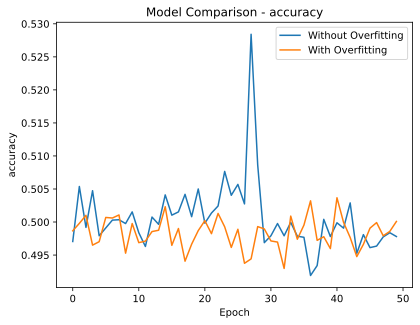

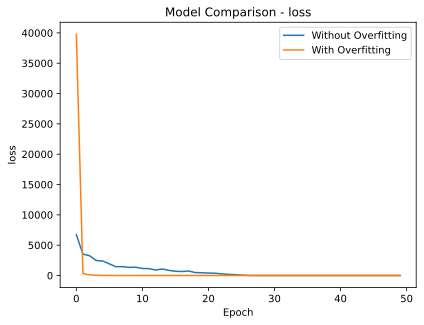

In [284]:
# So sánh độ chính xác
plot_comparison(fnn, fnn_dropout, metric='accuracy')
# So sánh hàm mất mát
plot_comparison(fnn, fnn_dropout, metric='loss')

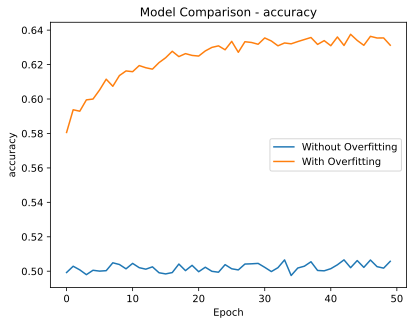

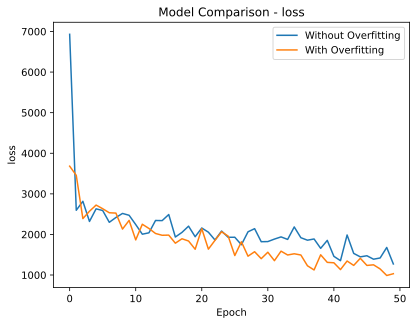

In [285]:
# So sánh độ chính xác
plot_comparison(rnn, rnn_dropout, metric='accuracy')
# So sánh hàm mất mát
plot_comparison(rnn, rnn_dropout, metric='loss')


# 5.1 Các giải pháp để cải tiến mô hình

Để cải thiện độ chính xác của mô hình sau khi đã huấn luyện, chúng ta có thể thực hiện các bước sau:

1.   Phân tích Trường hợp Sai: Xem xét các trường hợp mà mô hình dự đoán sai. Phân tích các false positives và false negatives để hiểu rõ hơn về lý do mô hình đưa ra các quyết định không chính xác.

2.   Tinh chỉnh Tham số Mô hình: Kiểm tra và điều chỉnh các tham số của mô hình. Sử dụng kỹ thuật tinh chỉnh hyperparameters như Grid Search hoặc Random Search để tìm ra các giá trị tham số tốt nhất.

3. Tăng cường Dữ liệu (Data Augmentation): Tăng kích thước của tập dữ liệu bằng cách thêm các biến thể của các mẫu hiện có hoặc tạo dữ liệu tổng hợp. Điều này có thể giúp mô hình học được từ nhiều biến thể hơn và cải thiện khả năng tổng quát hóa.

4. Điều chỉnh các yếu tố như độ sâu của cây (đối với cây quyết định), số lượng cây (đối với rừng ngẫu nhiên), hay số lượng layer và units (đối với mạng nơ-ron) để kiểm soát overfitting và underfitting.

Biện pháp đã sử dụng trong bài toán:

1.   Tinh chỉnh Tham số Mô hình: Kiểm tra và điều chỉnh các tham số của mô hình. Sử dụng kỹ thuật tinh chỉnh hyperparameters như Grid Search hoặc Random Search để tìm ra các giá trị tham số tốt nhất.

2. Điều chỉnh các yếu tố như độ sâu của cây (đối với cây quyết định), số lượng cây (đối với rừng ngẫu nhiên), hay số lượng layer và units (đối với mạng nơ-ron) để kiểm soát overfitting và underfitting.

**==> Kết quả đã được cải thiện, mô hình học chính xác hơn:**

